In [12]:
import numpy as np
import healpy as hp
from matplotlib import pyplot as plt
import pysm3
import pysm3.units as u
%matplotlib inline

Using PySM3 to simulate foreground and cmb maps. The noise is simulated as a random process and linked to the noise sensitivity of Planck

In [18]:
#simulating foregroud emission and noise at the different Planck frequencies

nside = 128
#lmax =200 #maximum multipole moment

# Planck frequencies (in GHz)
freqs = np.array([28.4,  44.1,  70.4,  100.0,  143.0,  217.0,  353.0,  545.0,  857.0])
n_freqs = len(freqs)

# Planck noise sensitivity (in uK_arcmin)
sens = np.array([150.,  162.,  210.,  77.4,  33.,  46.8, 154,  42.,  5016.])

#Importing models for foregrounds and cmb using pysm sky module

sky_d = pysm3.Sky(nside=nside, preset_strings=["d2"])
sky_s = pysm3.Sky(nside=nside, preset_strings=["s2"])
sky_f = pysm3.Sky(nside=nside, preset_strings=["f1"])
sky_cmb = pysm3.Sky(nside=nside, preset_strings=["c1"])

# Initialization of lists to collect maps of different components at different frequencies
noise_pl = []
dust_pl = []
sync_pl = []
ff_pl = []
cmb_pl =[]
for nf in range(n_freqs):
    #noise
    noise= (np.random.normal(size=(12 * nside**2)) * sens[nf] / hp.nside2resol(nside, True))
    noise_pl.append(noise)
    #foregrounds
    dust= sky_d.get_emission(freqs[nf] * u.GHz)[0] * u.uK_RJ.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freqs[nf] * u.GHz))
    dust_pl.append(dust)
    sync=sky_s.get_emission(freqs[nf] * u.GHz)[0] * u.uK_RJ.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freqs[nf] * u.GHz))

    sync_pl.append(sync)
    ff=sky_f.get_emission(freqs[nf] * u.GHz)[0] * u.uK_RJ.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freqs[nf] * u.GHz))
    ff_pl.append(ff)
    #cmb
    cmb = sky_cmb.get_emission(freqs[nf] * u.GHz)[0]* u.uK_RJ.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freqs[nf] * u.GHz))
    cmb_pl.append(cmb)


# Making lists numpy arrays. Their dimension is (N_freq,N_pixels).
noise_pl=np.array(noise_pl)
dust_pl=np.array(dust_pl)
sync_pl=np.array(sync_pl)
ff_pl=np.array(ff_pl)
cmb_pl = np.array(cmb_pl)


Combining the CMB and foreground maps to be input into ILC

In [19]:
maps_pl = cmb_pl + noise_pl + dust_pl + sync_pl + ff_pl #cmb and foregrounds combined
fgds_pl= dust_pl + sync_pl + ff_pl #combined foregrounds

Transforimng frequency maps to harmonic space by decomposition

In [67]:
#transform maps to spherical harmonics
for nf in range(n_freqs):
    alm_maps= hp.map2alm(maps_pl, lmax=None, mmax=None, iter=0, pol=False)
    alm_fgds= hp.map2alm(fgds_pl, lmax=None, mmax=None, iter=0, pol=False)

In [68]:
# alm contains a_lm(i) coefficients
print(alm_maps.shape) 
print(alm_fgds.shape) # Outputs: (lmax + 1)*(lmax + 2)//2, the number of coefficients
num_maps= len(alm_maps)
num_fgds= len(alm_fgds)

(9, 73920)
(9, 73920)


Calculating the inverse covariance of the combined map coefficients and foreground coefficients

In [69]:
for ell in range(num_maps):
    cov_maps= np.cov(alm_maps)
    inv_cov_maps = np.linalg.inv(cov_maps)

for ell in range(num_fgds):
    cov_fgds= np.cov(alm_fgds)
    inv_cov_fgds = np.linalg.inv(cov_fgds)

Compute weights for each $l$ multipole for both combined maps and foregrounds

In [70]:
#CMB spectral energy density
A_maps= np.ones(inv_cov_maps.shape[0]) 
A_fgds= np.ones(inv_cov_fgds.shape[0]) 
#array filled with values of 1. size (shape) =5

#Computing the weights for the combined maps:
for ell in range(num_maps):
    w_maps=(A_maps @ inv_cov_maps /(A_maps @ (inv_cov_maps @A_maps)))
    w_maps= np.sum(inv_cov_maps, axis =1)/np.sum(inv_cov_maps) #sums elements in an array. axis =1 sums along rows. None= sum of all elements

#Computing the weights for the foreground maps:
for ell in range(num_fgds):
    w_fgds=(A_fgds @ inv_cov_fgds /(A_fgds @ (inv_cov_fgds @A_fgds)))
    w_fgds= np.sum(inv_cov_fgds, axis =1)/np.sum(inv_cov_fgds) #sums elements in an array. axis =1 sums along rows. None= sum of all elements

Combining the weights to the maps to obtain the ILC

In [71]:
for ell in range(num_maps):
#Linearly combining the maps with the corresponding weights to obtain the output ILC solution for the maps, foregrounds, and noise
    map_ilc = np.einsum ('j, ji->i', w_maps, alm_maps)
for ell in range(num_fgds):
    fgds_ilc = np.einsum ('j, ji->i', w_fgds, alm_fgds)

Reconstructing the cleaned map

In [72]:
# Transform back to pixel space
ilc = hp.alm2map(map_ilc, nside=nside, lmax=None, mmax=None)
ilc_fgds = hp.alm2map(fgds_ilc, nside=nside, lmax=None, mmax=None)

In [75]:
diff = cmb_pl-ilc

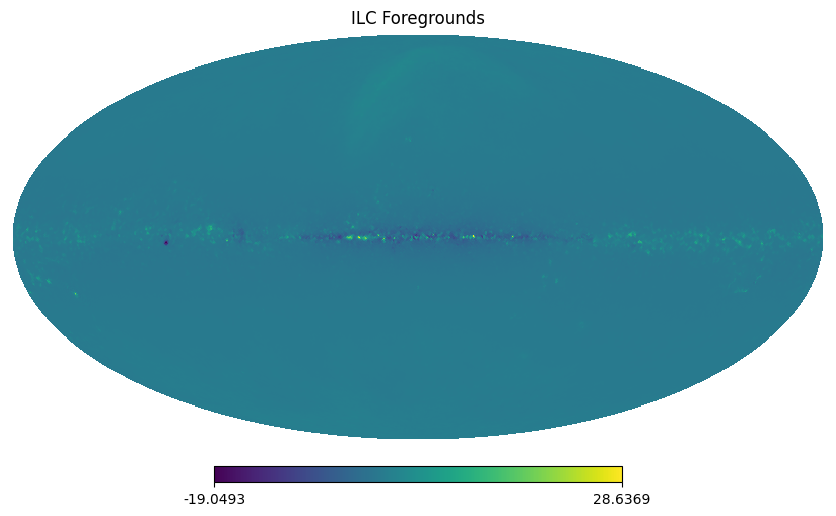

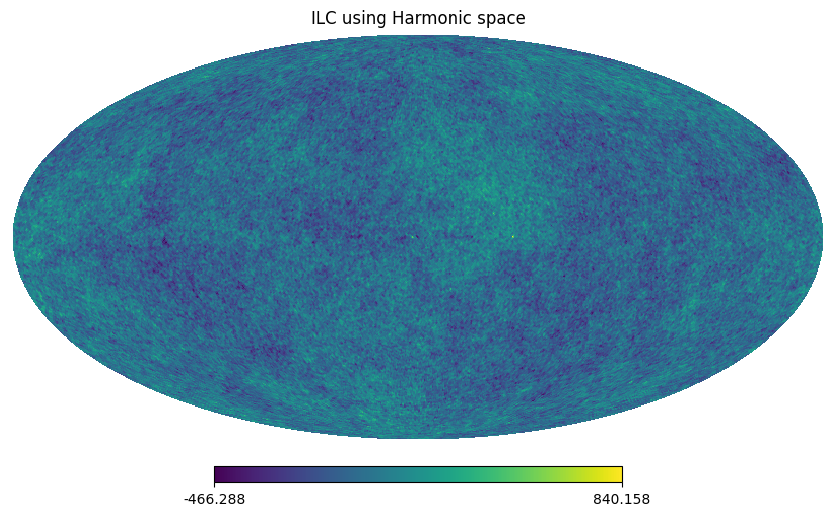

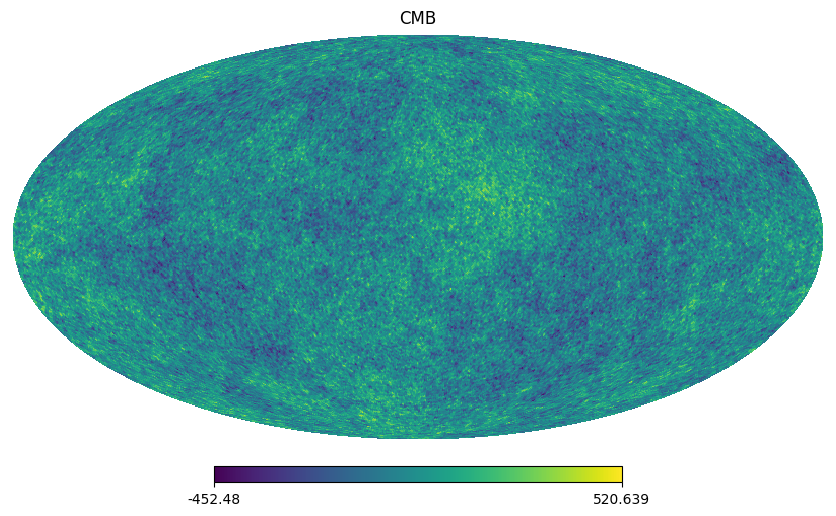

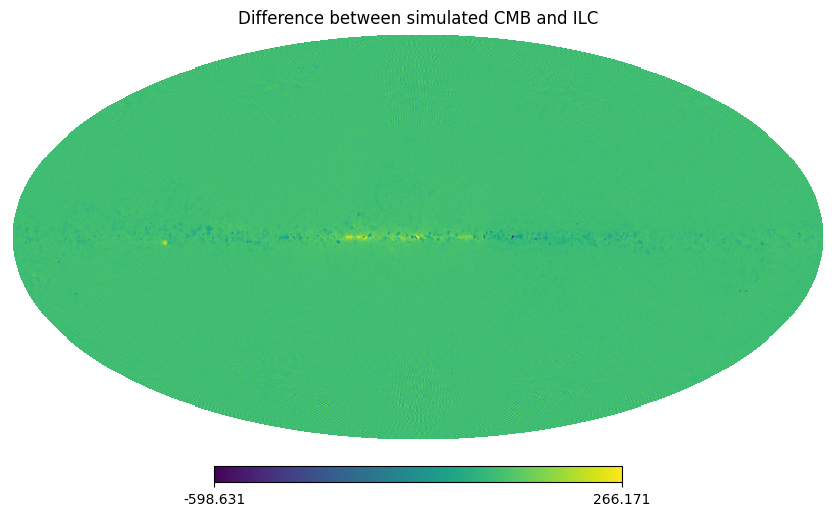

In [78]:
hp.mollview(ilc_fgds, title ="ILC Foregrounds", cmap="viridis")
hp.mollview(ilc, title ="ILC using Harmonic space", cmap="viridis")
#hp.mollview(noise_pl[0], title ="Noise", cmap="viridis")
hp.mollview(cmb_pl[0], title ="CMB", cmap="viridis")
hp.mollview(diff[0], title ="Difference between simulated CMB and ILC", cmap="viridis")